# Feature Governance - Loan Conditions

BayesRisk Project

**Author:** Desmond Momanyi Mariita

**Date:** 2026-01-11

---

## 1. Objectives
This batch focuses on the specific terms of the loan itself. Unlike the borrower's history, these are variables we (the lender) control or the borrower chooses.

The "Conditions" Variables:

1. loan_amnt: How much money are they asking for?

2. term: How long is the loan (36 or 60 months)?

3. purpose: Why do they want the money? (Consolidation, Wedding, Small Business?)

4. int_rate: The interest rate. (CRITICAL GOVERNANCE DECISION HERE).

The "Interest Rate" Dilemma
Governance Alert: Can we use int_rate as a feature?

- Argument FOR: It is highly predictive. Risky people get high rates.

- Argument AGAINST (The Leakage/Circularity Problem):

    - In a bank, the Risk Model outputs the Probability of Default (PD).

    - The Pricing Engine uses that PD to set the Interest Rate.

    - If you use Interest Rate to predict Default, you are using the output of the old model to train the new model. You are just learning "What did LendingClub think in 2015?" rather than "What is the actual risk?"

- Decision: DROP IT. If we are building a fundamental risk model (to beat the market or replace the old model), we cannot use the outcome of the pricing decision as an input.

#### 1. Setup & Load
Load the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the base file
file_path = '../../data/interim/loans_batch3.pkl'
df = pd.read_pickle(file_path)

# Define Conditions features
cond_cols = [
    'loan_amnt', 
    'term', 
    'purpose', 
    'int_rate', 
    'grade', 
    'sub_grade'
]

print(f"Analyzing {len(cond_cols)} condition features...")
display(df[cond_cols].head())

Analyzing 6 condition features...


,loan_amnt,term,purpose,int_rate,grade,sub_grade
0,5000.0,36 months,credit_card,10.65%,B,B2
1,2500.0,60 months,car,15.27%,C,C4
2,2400.0,36 months,small_business,15.96%,C,C5
3,10000.0,36 months,other,13.49%,C,C1
4,3000.0,60 months,other,12.69%,B,B5


#### 2. Loan Term Analysis
The term is usually "36 months" or "60 months".

- Hypothesis: 60-month loans are riskier (selection bias: people who need lower monthly payments choose longer terms).
- Expectation: We will see a significant jump in Bad Rate for 60-month loans.

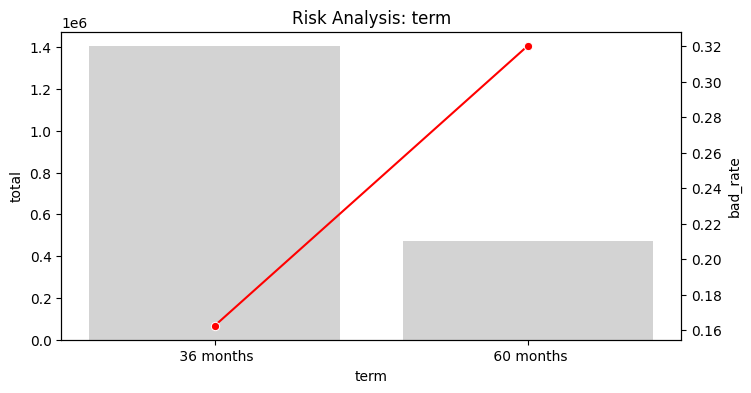

In [16]:
def plot_bad_rate(df, col):
    """
    Plots the bad rate (default probability) and volume for each category in a categorical column.
    
    Creates a dual-axis visualization with bar chart showing volume and line chart showing 
    bad rate (default probability).

    Args:
        df (pd.DataFrame): DataFrame containing the categorical column and 'target' column.
        col (str): Name of the categorical column to analyze.

    Returns:
        None: Displays a dual-axis plot.
    """
    group = df.groupby(col).agg(total=('target', 'count'), bad=('target', 'sum'))
    group['bad_rate'] = group['bad'] / group['total']
    
    fig, ax1 = plt.subplots(figsize=(8, 4))
    sns.barplot(x=group.index, y='total', data=group, color='lightgrey', ax=ax1)
    ax2 = ax1.twinx()
    sns.lineplot(x=group.index, y='bad_rate', data=group, color='red', marker='o', ax=ax2)
    plt.title(f'Risk Analysis: {col}')
    plt.show()

# Analyze Term
plot_bad_rate(df, 'term')

#### 3. Purpose Analysis (The "Why")
purpose tells you the intent.

- Consolidation: Usually neutral/good (trying to fix finances).

- Small Business: Very high risk (startups fail).

- Wedding/Vacation: Variable risk.

Governance Check: Are there too many categories? "educational", "renewable_energy" might have tiny volumes. We might need to group them into "other".

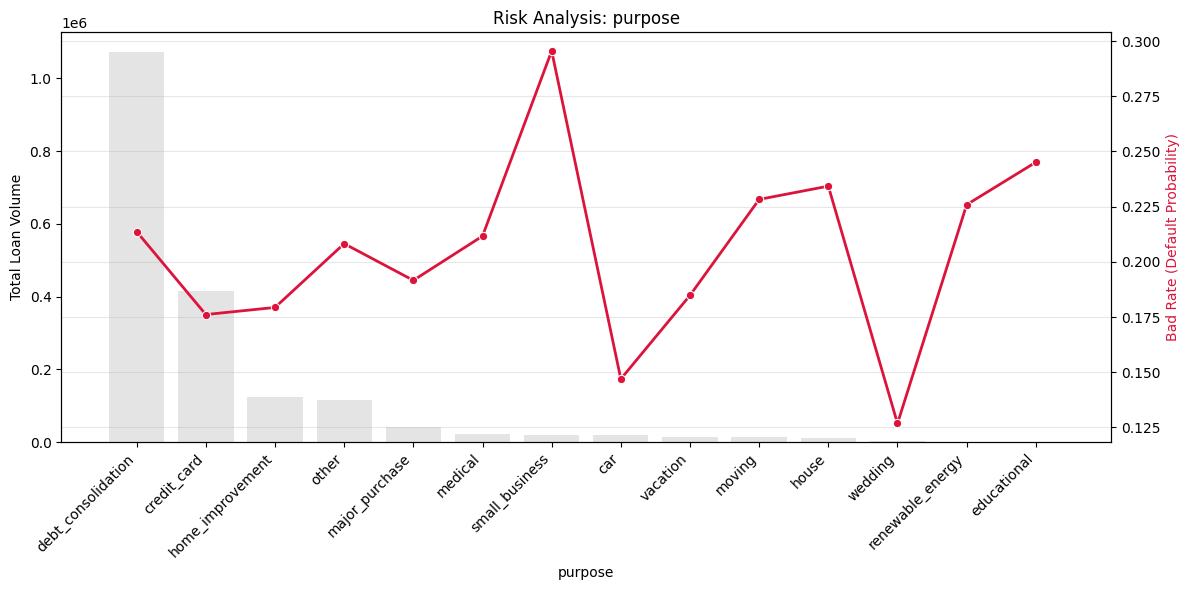

In [13]:
def plot_bad_rate(df, col):
    """
    Plots the bad rate (default probability) and volume for each category in a categorical column.
    
    Creates a dual-axis visualization with bar chart showing volume and line chart showing 
    bad rate (default probability). Data is sorted by volume in descending order. X-axis 
    labels are rotated for readability.

    Args:
        df (pd.DataFrame): DataFrame containing the categorical column and 'target' column.
        col (str): Name of the categorical column to analyze.

    Returns:
        None: Displays a dual-axis plot.
    """
    # Aggregate data
    group = df.groupby(col).agg(total=('target', 'count'), bad=('target', 'sum'))
    group['bad_rate'] = group['bad'] / group['total']
    
    # Sort by volume so the plot is ordered
    group = group.sort_values('total', ascending=False)
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Bar Chart (Volume)
    sns.barplot(x=group.index, y='total', data=group, color='lightgrey', alpha=0.6, ax=ax1)
    ax1.set_ylabel('Total Loan Volume')
    ax1.set_xlabel(col)
    
    # Line Chart (Risk)
    ax2 = ax1.twinx()
    sns.lineplot(x=group.index, y='bad_rate', data=group, marker='o', color='crimson', lw=2, ax=ax2)
    ax2.set_ylabel('Bad Rate (Default Probability)', color='crimson')
    
    # --- FIX for UserWarning ---
    # 1. Explicitly set the tick positions (0, 1, 2, etc.)
    ax1.set_xticks(range(len(group)))
    # 2. Then set the labels with rotation
    ax1.set_xticklabels(group.index, rotation=45, ha='right')
    
    plt.title(f'Risk Analysis: {col}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run it
plot_bad_rate(df, 'purpose')

#### 4. Governance & Cleaning Function
We drop the circular variables (int_rate, grade) and clean the structural ones.

In [5]:
def clean_condition_features(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    Applies governance transformations to Loan Condition features.

    Operations:
    1. term: 
       - Converts string " 36 months" to integer 36.
    2. purpose:
       - Consolidates low-volume categories (educational, renewable_energy, wedding) 
         into 'other' to prevent overfitting on noise.
    3. DROPS:
       - int_rate, grade, sub_grade: These are outcomes of the existing risk model. 
         Using them causes 'Model Circularity' (simulating the old model rather than 
         predicting raw risk).

    Args:
        df_in (pd.DataFrame): Dataframe containing condition columns.

    Returns:
        pd.DataFrame: A dataframe with clean condition features.
    """
    df_out = df_in.copy()
    
    # --- 1. Clean Term ---
    # Extract integer if it's a string. 
    # NOTE: We use r'' (raw string) for the regex to avoid the SyntaxWarning
    if df_out['term'].dtype == 'O':
        df_out['term_clean'] = df_out['term'].str.extract(r'(\d+)').astype(float)
    else:
        df_out['term_clean'] = df_out['term']
        
    # --- 2. Clean Purpose ---
    valid_purposes = [
        'debt_consolidation', 'credit_card', 'home_improvement', 
        'other', 'major_purchase', 'small_business', 'car', 'medical'
    ]
    
    df_out['purpose_clean'] = df_out['purpose'].apply(
        lambda x: x if x in valid_purposes else 'other'
    )
    
    # --- 3. Drop Circular Features ---
    drop_cols = ['int_rate', 'grade', 'sub_grade', 'term', 'purpose']
    cols_to_drop = [c for c in drop_cols if c in df_out.columns]
    df_out.drop(columns=cols_to_drop, inplace=True)
    
    return df_out

# Apply Cleaning
df_clean_cond = clean_condition_features(df)

print("Batch 4 Cleaning Complete.")
display(df_clean_cond[['term_clean', 'purpose_clean']].head())

Batch 4 Cleaning Complete.


,term_clean,purpose_clean
0,36.0,credit_card
1,60.0,car
2,36.0,small_business
3,36.0,other
4,60.0,other


In [17]:
df_clean_cond.to_pickle('../../data/interim/loans_batch4.pkl')
print("Base modeling data saved.")

Base modeling data saved.
